In [16]:
import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [17]:
df_test = pd.read_csv("./2018-E-c-En-test-gold.csv", sep=';')

not_chosen_columns = ['ID', 'Tweet']
label_columns = [col for col in df_test.columns if col not in not_chosen_columns]

df_labels_test = df_test[label_columns]

list_labels_test = df_labels_test.values.tolist()

test_texts = df_test['Tweet'].tolist()
test_labels = list_labels_test

tokenizer = BertTokenizer.from_pretrained("saved_model_i1_f")
model = BertForSequenceClassification.from_pretrained("saved_model_i1_f")

In [18]:
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

all_predictions = []

# Process each text
for text in test_texts:
    inputs = tokenizer(text, padding=True, truncation=True, return_tensors="pt")
    inputs = inputs.to(device)

    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    probabilities = torch.sigmoid(logits)  # Apply sigmoid to convert logits to probabilities
    probabilities = probabilities.squeeze(0)
    probabilities = probabilities.cpu()

    #threshold = 0.5
    threshold = torch.tensor([0.41, 0.37, 0.36, 0.48, 0.47, 0.62, 0.39, 0.49, 0.37, 0.47, 0.56])
    predicted_labels = (probabilities > threshold).long()

    all_predictions.append(predicted_labels) #Değiştir

Accuracy: 0.8655

Label - anger: Precision=0.7882, Recall=0.7639, F1-score=0.7758


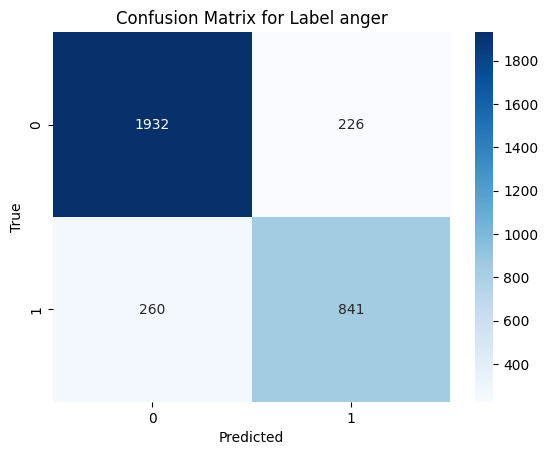

Label - anticipation: Precision=0.3423, Recall=0.3600, F1-score=0.3509


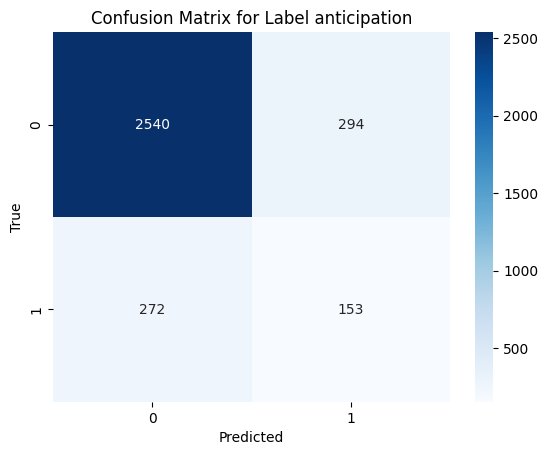

Label - disgust: Precision=0.7238, Recall=0.7989, F1-score=0.7595


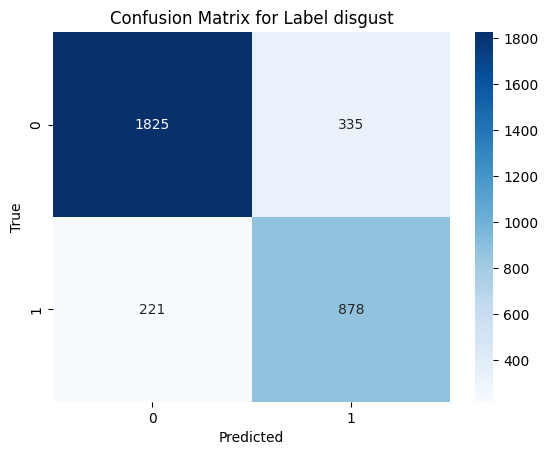

Label - fear: Precision=0.7922, Recall=0.7155, F1-score=0.7519


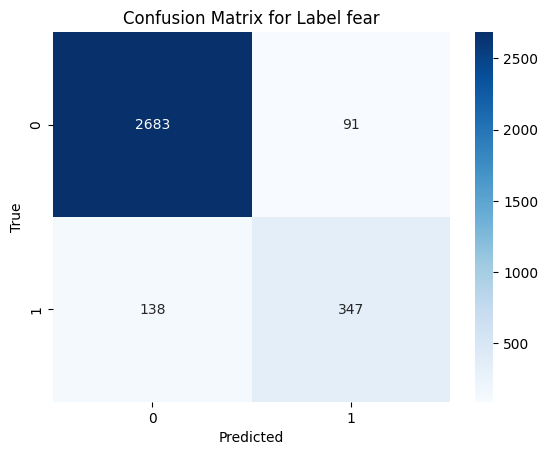

Label - joy: Precision=0.8665, Recall=0.8190, F1-score=0.8421


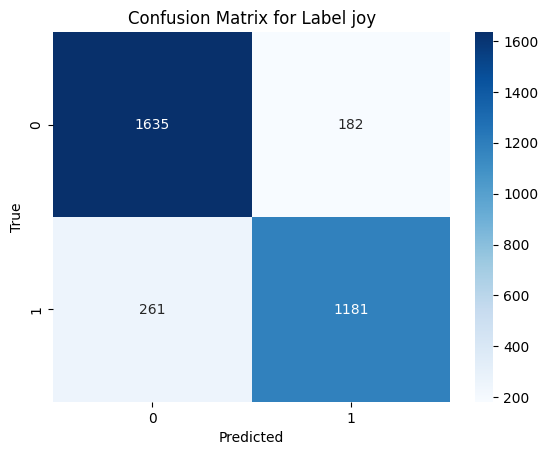

Label - love: Precision=0.6381, Recall=0.5329, F1-score=0.5808


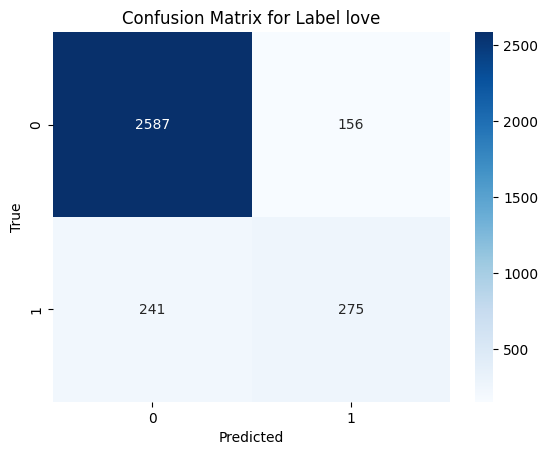

Label - optimism: Precision=0.6932, Recall=0.7769, F1-score=0.7327


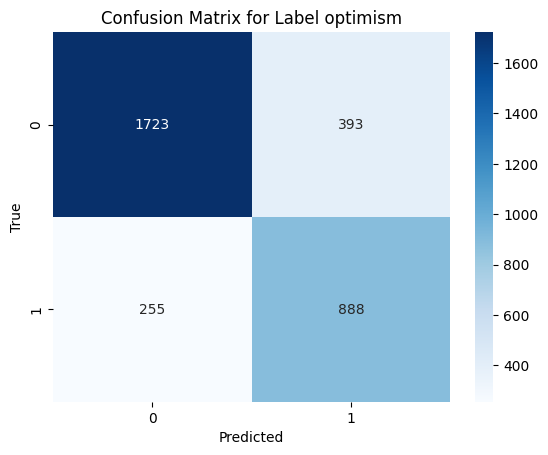

Label - pessimism: Precision=0.3794, Recall=0.4613, F1-score=0.4164


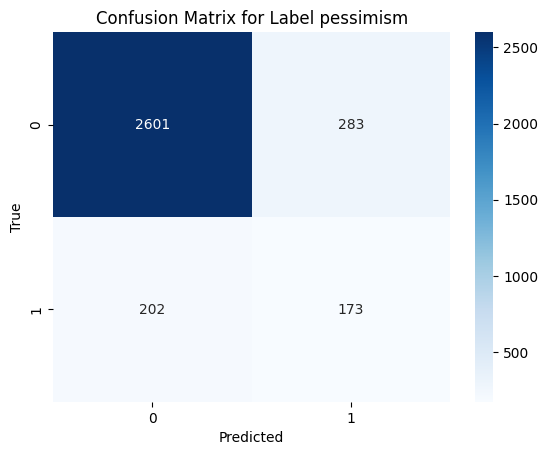

Label - sadness: Precision=0.6906, Recall=0.7208, F1-score=0.7054


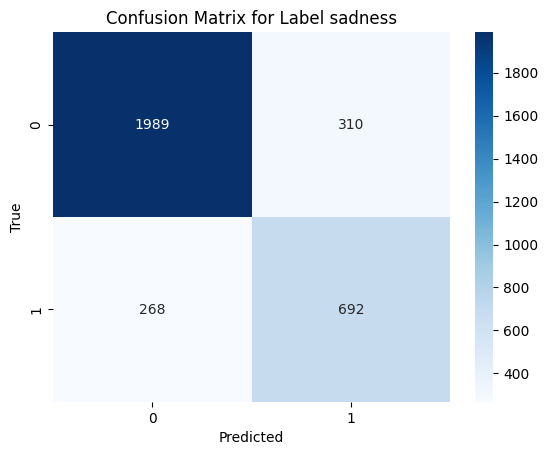

Label - surprise: Precision=0.3333, Recall=0.2706, F1-score=0.2987


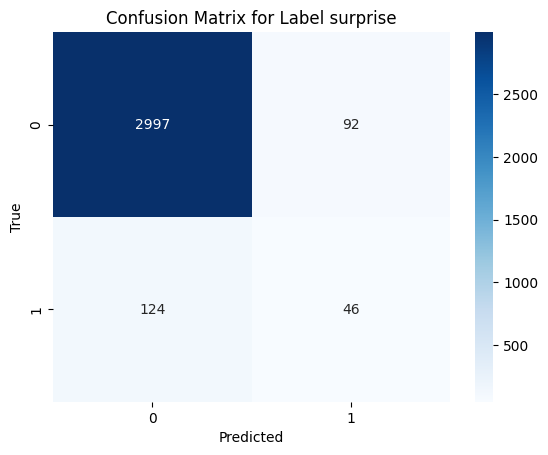

Label - trust: Precision=0.2556, Recall=0.2222, F1-score=0.2378


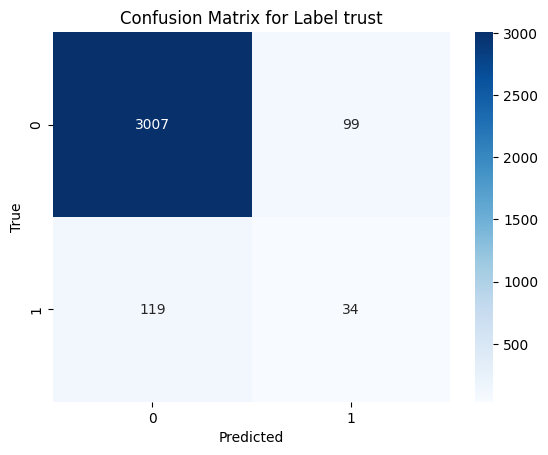


Macro - F1-score: 0.5865, Precision: 0.5912, Recall: 0.5856
Micro - F1-score: 0.6955, Precision: 0.6912, Recall: 0.7000
Weighted - F1-score: 0.6957, Precision: 0.6945, Recall: 0.7000


In [19]:
true_labels_n = torch.tensor(test_labels).to(device)
all_predictions_n = torch.stack(all_predictions).to(true_labels_n.device)

emotions = ["anger", "anticipation", "disgust", "fear", "joy", "love", "optimism", "pessimism", "sadness", "surprise", "trust"]

correct = (all_predictions_n == true_labels_n).float().sum().item()  # Count correct predictions
total = torch.numel(true_labels_n)  # Total number of labels
accuracy = correct / total  # Compute accuracy

print(f"Accuracy: {accuracy:.4f}\n")

# Convert tensors to numpy arrays for sklearn
predicted_labels_np = all_predictions_n.cpu().numpy()
true_labels_np = true_labels_n.cpu().numpy()

for i in range(true_labels_np.shape[1]):  # Iterate through each of the 11 labels
    precision = precision_score(true_labels_np[:, i], predicted_labels_np[:, i], zero_division=0)
    recall = recall_score(true_labels_np[:, i], predicted_labels_np[:, i], zero_division=0)
    f1 = f1_score(true_labels_np[:, i], predicted_labels_np[:, i], zero_division=0)
    print(f"Label - {emotions[i]}: Precision={precision:.4f}, Recall={recall:.4f}, F1-score={f1:.4f}")

    cm = confusion_matrix(true_labels_np[:, i], predicted_labels_np[:, i])
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix for Label {emotions[i]}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

f1 = f1_score(true_labels_np, predicted_labels_np, average="macro")
precision = precision_score(true_labels_np, predicted_labels_np, average="macro")
recall = recall_score(true_labels_np, predicted_labels_np, average="macro")

print(f"\nMacro - F1-score: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")

f1 = f1_score(true_labels_np, predicted_labels_np, average="micro")
precision = precision_score(true_labels_np, predicted_labels_np, average="micro")
recall = recall_score(true_labels_np, predicted_labels_np, average="micro")

print(f"Micro - F1-score: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")

f1 = f1_score(true_labels_np, predicted_labels_np, average="weighted")
precision = precision_score(true_labels_np, predicted_labels_np, average="weighted")
recall = recall_score(true_labels_np, predicted_labels_np, average="weighted")

print(f"Weighted - F1-score: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")
